In [1]:
import gymnasium as gym
from matplotlib import pyplot as plt
import re
import numpy as np
from tqdm.notebook import trange, tqdm
from math import floor

In [2]:

def row_col_to_seq(row_col, num_cols):
    '''
    Converts row_col to num_cols format

    Args:
        row_col (np.ndarray): Location of shape (1,2)
        num_cols (int): Total number of cols
    Return:
        (np.ndarray): Number format of row and column of shape (1,)
  '''
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols):
    '''
    Converts state number to rol_col format
    Args:
        seq (int): Number format of state
        num_cols (int): Number of columns
    Return:
        (np.ndarray): Array of shape (1,2) as [[row, col]]
    '''
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [27]:
DOWN = 0
UP = 1
LEFT = 3
RIGHT = 2
PICKUP = 4
DROP = 5

def policy_ep(q_values, state, ep):
    '''   
    Function to implement epsilon greedy
    '''
    num_actions = q_values.shape[1]
    rand_num = np.random.random()
    if rand_num < ep:
        action = np.random.choice(np.arange(num_actions))
    else:
        action = np.argmax(q_values[state,:])

    return action



def plot_Q(Q, message = "Q plot"):
    ''' 
    Function to plot Q values as heat map
    '''

    fig = plt.figure(figsize=(6,5))
    plt.title(message, fontsize = 10)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2,  cmap = 'GnBu')
    #c_bar = plt.colorbar()
    #c_bar.ax.tick_params(labelsize= 8)
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        if a in [PICKUP, DROP]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        if a in [PICKUP, DROP]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    #plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()


(-0.5, 549.5, 349.5, -0.5)

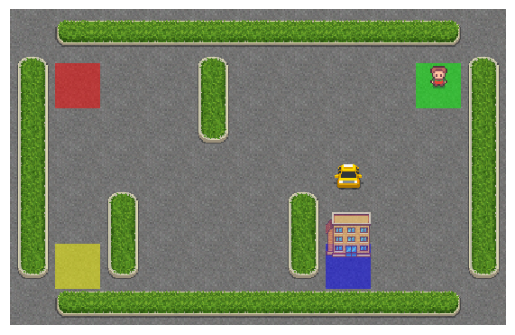

In [4]:
# Environment
env = gym.make('Taxi-v3', render_mode = 'rgb_array')
s = env.reset()
plt.imshow(env.render())
plt.axis('off')

In [5]:

def run_option(state, option, ep, q_vals):
    '''
    Function to take a step within an option
    '''
    opt_terminal_states = {0:[0,0], 1:[0,4], 2:[4,0],3:[4,3]}
    # Decoding state for row, col, pass_loc, dest_loc
    taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)
    state_act_seq = row_col_to_seq(np.array([[taxi_row,taxi_col]]), 5)
    # Getting row and col for option terminal loc
    taxi_target_row, taxi_target_col = opt_terminal_states[option]

    # Checking if target loc is reached or not
    if taxi_row == taxi_target_row and taxi_col == taxi_target_col:
        #print(f'Taxi checks: state = {taxi_row}, {taxi_col}, target = {taxi_target_row},{taxi_target_col}')

        # Goal point reached
        optdone = True
        # check passeger loc
        if option == pass_loc:
            action = 4
        elif option == dest_loc:
            action = 5
        else:
            action = 1 if (option in [0,1]) else 0
    else:
        optdone = False
        # Choosing action
        action = policy_ep(q_vals[:,:,option], state_act_seq, ep)

    return action,optdone

In [19]:
def train_smdp(env,num_episodes):
    ''' 
    Function to learn Q values using SMDP Q learning
    '''
    row = 5
    col = 5
    num_pass_loc = 5
    num_dest_loc = 4
    num_options = 4 # Goto R, G, Y, B
    num_primitive_act = 6
    num_states = 500
    tot_actions = num_primitive_act + num_options

    gamma = 0.9
    alpha = 0.1
    ep = 0.01

    #num_episodes = 5000
    opt_terminal_states = {0:[0,0], 1:[0,4], 2:[4,0],3:[4,3]}
    q_val_opt = np.zeros((num_pass_loc*num_dest_loc, num_options)) # shape= (20,4)
    q_val_actions = np.zeros((row*col, num_primitive_act, num_options)) # shape (25,6,4)

    
    reward_epsiode_monitor = []
    num_steps_monitor = []

    for i in tqdm(range(num_episodes)):
        curr_state = env.reset()[0]
        #taxi_start_row, taxi_start_col, pass_loc, dest_idx = env.decode(curr_state)
        done = False
        steps = 0
        tot_reward = 0

        while not done:
            # Decoding state
            taxi_row, taxi_col, pass_loc, dest_idx = env.decode(curr_state)
            curr_opt_seq = row_col_to_seq(np.array([[pass_loc, dest_idx]]), num_dest_loc)

            # choose option
            option = policy_ep(q_val_opt, curr_opt_seq, ep)

            optdone = False
            reward_bar = 0
            opt_start_state = curr_opt_seq
            k = 0

            while not optdone:
                opt_action,optdone = run_option(state = curr_state,
                                                option = option,
                                                ep = ep,
                                                q_vals = q_val_actions)
                next_state, reward, is_terminal, truncated, t_prob = env.step(opt_action)
                reward_bar = gamma*reward_bar + reward
                tot_reward = tot_reward + reward

                # decode curr, next state
                taxi_curr_row, taxi_curr_col, pass_curr_loc, dest_curr_idx = env.decode(curr_state)
                taxi_next_row, taxi_next_col, pass_next_loc, dest_next_idx = env.decode(next_state)
                curr_act_seq = row_col_to_seq(np.array([[taxi_curr_row,taxi_curr_col]]), 5)
                next_act_seq = row_col_to_seq(np.array([[taxi_next_row,taxi_next_col]]), 5)

                q_val_actions[curr_act_seq,opt_action,option] = q_val_actions[curr_act_seq,opt_action,option] + alpha * (reward + gamma * np.max(q_val_actions[next_act_seq,:,option]) - q_val_actions[curr_act_seq,opt_action,option])

                if is_terminal:
                    done = True
                if optdone:
                    opt_terminal_state = next_state
                k += 1
                steps += 1
                curr_state = next_state
                #ep_opt[option] = ep_min #max(ep_min,decay*ep_opt[option])

            #decode and encode option start and end
            opt_start_row, opt_start_col, pass_start_loc, dest_start_idx = env.decode(opt_start_state)
            opt_end_row, opt_end_col, pass_end_loc, dest_end_idx = env.decode(opt_terminal_state)
            curr_opt_seq = row_col_to_seq(np.array([[pass_start_loc,dest_start_idx]]), 4)
            end_opt_seq = row_col_to_seq(np.array([[pass_end_loc,dest_end_idx]]), 4)
            q_val_opt[curr_opt_seq, option] = q_val_opt[curr_opt_seq, option] + alpha * (reward_bar + (gamma**k)*np.max(q_val_opt[end_opt_seq]) - q_val_opt[curr_opt_seq, option])

        reward_epsiode_monitor.append(tot_reward)
        num_steps_monitor.append(steps)

        #print(f'ep = {i}, steps = {steps}, total reward = {tot_reward},')
    return reward_epsiode_monitor, num_steps_monitor, q_val_opt, q_val_actions



In [ ]:
num_episodes = 5000
num_runs = 5
rew_monitor = np.zeros((num_runs, num_episodes))
steps_monitor = np.zeros((num_runs, num_episodes))
for i in range(num_runs):
    env = gym.make('Taxi-v3')
    env.reset()
    rew, steps, _, _ = train_smdp(env, num_episodes)
    rew_monitor[i] = rew
    steps_monitor[i] = steps

Text(0, 0.5, 'Reward')

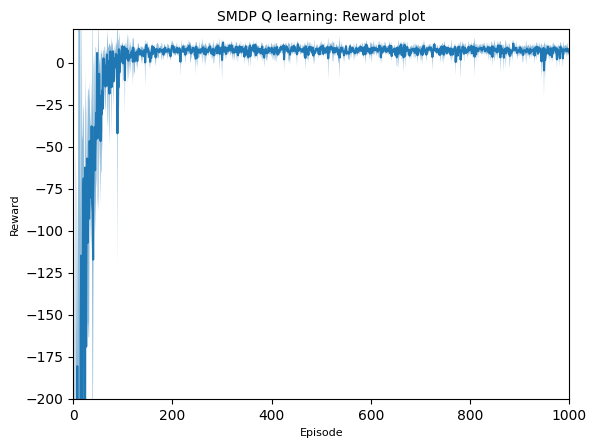

In [8]:
mean_rew = np.mean(rew_monitor, axis = 0)
se_rew = np.std(rew_monitor, axis = 0)
plt.plot(mean_rew)
plt.fill_between(np.arange(5000), 
                 mean_rew - se_rew, 
                 mean_rew + se_rew, 
                 alpha = 0.5)
plt.ylim(-200,20)
plt.xlim(0,1000)
plt.title('SMDP Q learning: Reward plot', fontsize = 10)
plt.xlabel('Episode', fontsize = 8)
plt.ylabel('Reward', fontsize = 8)

In [9]:
import pickle
with open('Reward_SMDP.pkl','wb') as f:
     pickle.dump(rew_monitor, f)

In [21]:
num_episodes= 1000
env = gym.make('Taxi-v3')
env.reset()
rew, steps, q_val_opt, q_val_actions = train_smdp(env, num_episodes)

  0%|          | 0/1000 [00:00<?, ?it/s]

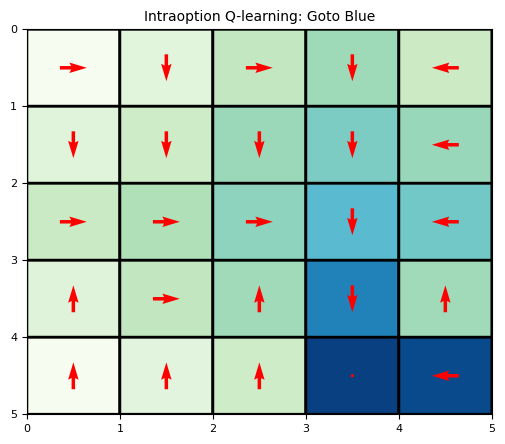

In [31]:
# Goto R, G, Y, B
Q_v = q_val_actions[:,:,3]
Q_v = np.reshape(Q_v,(5,5,6))
plot_Q(Q_v, 'SMDP Q-learning: Goto Blue')

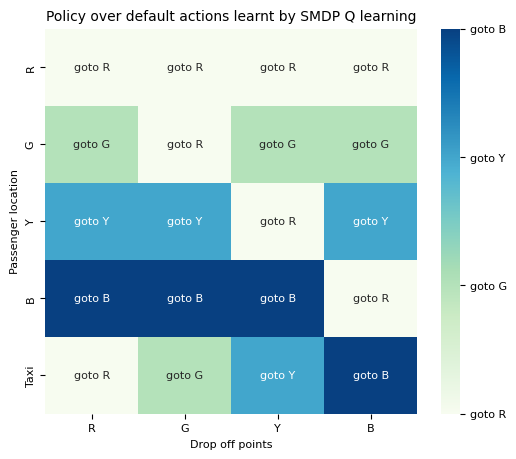

In [41]:
import seaborn as sns

Qmax_SMDP = np.argmax(q_val_opt,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)

figure, axis = plt.subplots(1, 1,figsize=(6,5))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '', cmap = 'GnBu', annot_kws={"size":8})
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
c_bar.ax.tick_params(labelsize= 8)
#c_bar.set_ticklabels(['south','north','east','west','pick up','drop'])
axis.set_xlabel('Drop off points', fontsize = 8)
axis.set_ylabel("Passenger location",fontsize = 8)
axis.set_title('Policy over default actions learnt by SMDP Q learning', fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()